### **Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier,IsolationForest
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
import copy



## Data

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
# df=pd.read_csv('/content/sample_submission.csv')
tr=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")


In [4]:
tr.shape

(3116945, 22)

In [5]:
tr.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,4.51,15.39,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,4.79,6.48,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,6.85,9.93,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,4.16,6.53,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,3.37,8.36,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [6]:
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [7]:
df_train = copy.deepcopy(tr)

# **Category**

In [8]:
def subclass_details (df):
  df=df.select_dtypes(include='category')
  for col in df.columns:
    print('Number of unique classes:',df[col].nunique())
    print(df[col].value_counts().head(10))
    print('############################')

In [9]:
def remove_att(df,threshold=200):
  cat_coln=df.select_dtypes(include='object')
  for col in cat_coln:
    attrib_drop=[]
    for att , count in df[col].value_counts().items() :
      if count <threshold:
        attrib_drop.append(att)
    mask = df[col].isin(attrib_drop)
    df.loc[mask,col] = 'UNK'
  return df

In [10]:
def convert_cate (df):
  for clas in df.select_dtypes(include='object'):
    df[clas] =   df[clas].astype('category')
  return df

In [11]:
df_train = remove_att(df_train)
df_train = convert_cate(df_train)
subclass_details(df_train)

Number of unique classes: 2
class
p    1705396
e    1411549
Name: count, dtype: int64
############################
Number of unique classes: 8
cap-shape
x      1436026
f       676238
s       365146
b       318646
o       108835
p       106967
c       104520
UNK        527
Name: count, dtype: int64
############################
Number of unique classes: 12
cap-surface
t    460777
s    384970
y    327826
h    284460
g    263729
d    206832
k    128875
e    119712
i    113440
w    109840
Name: count, dtype: int64
############################
Number of unique classes: 13
cap-color
n    1359542
y     386627
w     379442
g     210825
e     197290
o     178847
p      91838
r      78236
u      73172
b      61313
Name: count, dtype: int64
############################
Number of unique classes: 3
does-bruise-or-bleed
f      2569743
t       547085
UNK        109
Name: count, dtype: int64
############################
Number of unique classes: 8
gill-attachment
a      646034
d      589236
x      3608

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype   
---  ------                -----   
 0   id                    int64   
 1   class                 category
 2   cap-diameter          float64 
 3   cap-shape             category
 4   cap-surface           category
 5   cap-color             category
 6   does-bruise-or-bleed  category
 7   gill-attachment       category
 8   gill-spacing          category
 9   gill-color            category
 10  stem-height           float64 
 11  stem-width            float64 
 12  stem-root             category
 13  stem-surface          category
 14  stem-color            category
 15  veil-type             category
 16  veil-color            category
 17  has-ring              category
 18  ring-type             category
 19  spore-print-color     category
 20  habitat               category
 21  season                category
dtypes: category(18), f

# **Missing Value**

In [13]:
def plot_missing_feature(df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  sns.barplot(x=null_df.index,y=null_df.values,palette='plasma')
  plt.xticks(rotation=90)
  plt.xlabel('Feature')
  plt.ylabel('Percent(%)')
  plt.title('Missing Values')
  plt.show()

In [14]:
def missing_feature (df):
  null_df=(df.isna().sum()*100/df.shape[0]).sort_values(ascending=False)
  return null_df

In [15]:
null_df_train = missing_feature(df_train)
null_df_train

veil-type               94.884350
spore-print-color       91.425482
stem-root               88.452732
veil-color              87.936970
stem-surface            63.551362
gill-spacing            40.373988
cap-surface             21.528227
gill-attachment         16.809280
ring-type                4.134818
gill-color               0.001829
habitat                  0.001444
cap-shape                0.001283
stem-color               0.001219
has-ring                 0.000770
cap-color                0.000385
does-bruise-or-bleed     0.000257
cap-diameter             0.000128
id                       0.000000
stem-width               0.000000
class                    0.000000
stem-height              0.000000
season                   0.000000
dtype: float64

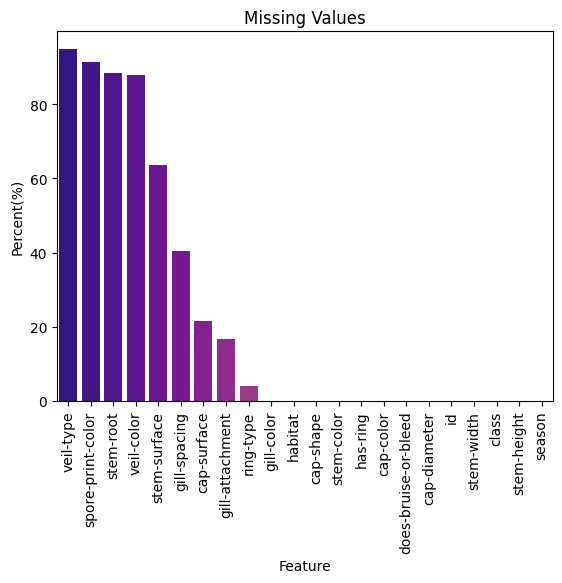

In [16]:
plot_missing_feature(df_train)

In [17]:
def columns_drop(df):
  column_drop=[]
  null_df=missing_feature(df)
  for col,val in null_df.items():
    if val >4:
      column_drop.append(col)
  return column_drop

In [18]:
column_drop_train = columns_drop(df_train)
print('-----------------------------------------')
print(column_drop_train)

-----------------------------------------
['veil-type', 'spore-print-color', 'stem-root', 'veil-color', 'stem-surface', 'gill-spacing', 'cap-surface', 'gill-attachment', 'ring-type']


In [19]:
df_train.drop(column_drop_train,axis=1,inplace=True)
df_train.drop('id',axis=1,inplace=True)

In [20]:
df_train.isna().sum()

class                    0
cap-diameter             4
cap-shape               40
cap-color               12
does-bruise-or-bleed     8
gill-color              57
stem-height              0
stem-width               0
stem-color              38
has-ring                24
habitat                 45
season                   0
dtype: int64

array([<Axes: ylabel='Frequency'>, <Axes: ylabel='Frequency'>,
       <Axes: ylabel='Frequency'>], dtype=object)

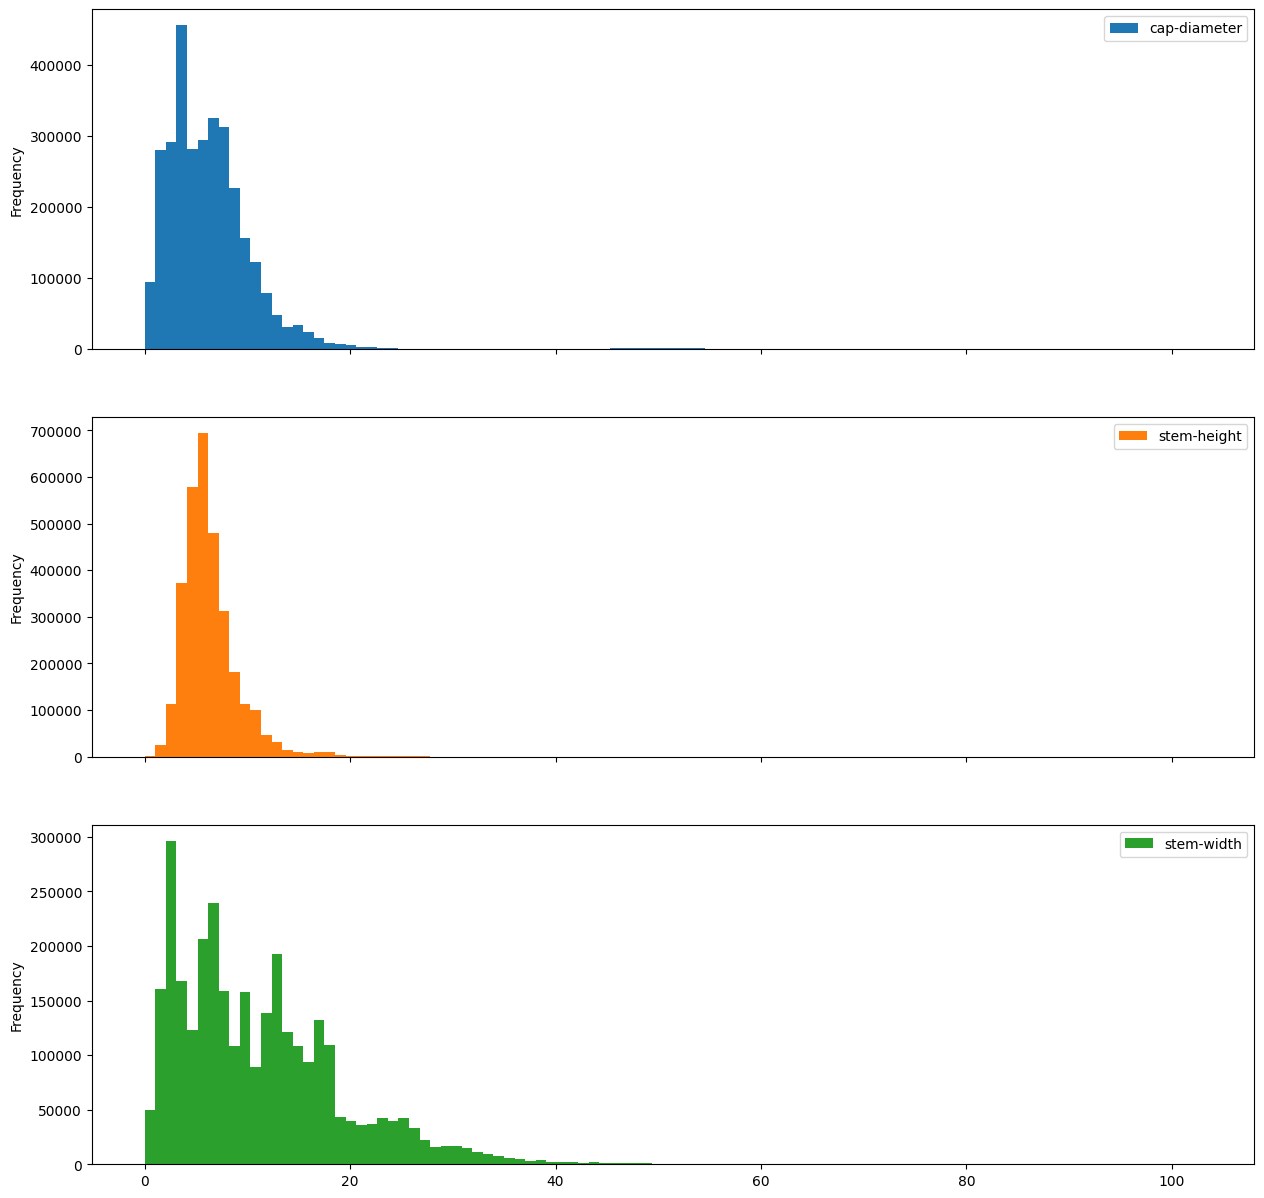

In [21]:
df_train.plot(kind='hist',subplots=True,sharex=True,figsize=(15,15),bins=100)

# **Splitting Data**

In [22]:
x=df_train.drop('class',axis=1)
y=df_train['class']
y=np.array([0 if i =='e' else 1 for i in y])
y.reshape(-1,1)

array([[0],
       [1],
       [0],
       ...,
       [1],
       [0],
       [1]])

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=.7,stratify=y)

# **Pipeline**

In [24]:
num_data_train_columns = x.select_dtypes(include='number').columns
cat_data_train_columns = x.select_dtypes(include='category').columns
cat_data_train_columns

Index(['cap-shape', 'cap-color', 'does-bruise-or-bleed', 'gill-color',
       'stem-color', 'has-ring', 'habitat', 'season'],
      dtype='object')

In [25]:
num_pipe=Pipeline (steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
cat_pipe=Pipeline (steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    # ('encoder',OneHotEncoder(sparse=False, handle_unknown='ignore'))
    ('encoder',OrdinalEncoder())

])

In [26]:
df_preprocessing=ColumnTransformer(
     transformers=[
        ('num', num_pipe, num_data_train_columns),
        ('cat', cat_pipe, cat_data_train_columns)
    ]
)

In [27]:
final_pipe = Pipeline(steps=[
    ('preprocessor',df_preprocessing)
    # ('PCA',PCA(n_components=.95)),
#     ('MCA',prince.MCA( n_components=2,  n_iter=3,       check_input=True, engine='auto',   random_state=42))

])

In [28]:
x_train=final_pipe.fit_transform(x_train)
x_test=final_pipe.transform(x_test)

In [29]:
isolation_forest = IsolationForest(contamination=0.024, random_state=42)
x_train_labels = isolation_forest.fit_predict(x_train) # 1 indicate normal, -1--> outlier (anomaly)
normal_label_boolean = x_train_labels !=-1
x_train = x_train[normal_label_boolean]
y_train = y_train[normal_label_boolean]

In [30]:
1-len(x_train)/len(x_train_labels)

0.02399786237528423

# **Modeling**

In [31]:
def Bayesian_Optimization (model,search_space):
  bayes = BayesSearchCV(model,
                        search_space,
                         n_iter= 20,
                        n_jobs=-1,
                        scoring='accuracy',
                        random_state=42)
  return bayes

In [32]:
xgb_space = {
    'n_estimators': Integer(50, 150),
    'max_depth': Integer(2, 8),
    'learning_rate': Real(0.01, .4, 'log-uniform'),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'alpha':Real(.1,.5,'uniform'),
    'min_child_weight':Integer(5,10)
}

In [33]:
xgb = XGBClassifier(random_state=42,use_label_encoder=False)
xgb_optimzied = Bayesian_Optimization(xgb,xgb_space)

In [34]:
xgb_optimzied.fit(x_train,y_train)

BayesSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                      callbacks=None, colsample_bylevel=None,
                                      colsample_bynode=None,
                                      colsample_bytree=None, device=None,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, feature_types=None,
                                      gamma=None, grow_policy=None,
                                      importance_type=None,
                                      interaction_constraints=None,
                                      learning_rate=None, max_...
                             'learning_rate': Real(low=0.01, high=0.4, prior='log-uniform', transform='normalize'),
                             'max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'min_child_weight': Integer(low=5, high=10, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=150, prior='uniform', transform='normalize'),
                             'subsample': Real(low=0.5, high=1.0, prior='uniform', transform='normalize')})

In [35]:
xgb_optimzied.best_params_

OrderedDict([('alpha', 0.5),
             ('colsample_bytree', 1.0),
             ('learning_rate', 0.4),
             ('max_depth', 8),
             ('min_child_weight', 10),
             ('n_estimators', 150),
             ('subsample', 1.0)])

In [36]:
xgb=xgb_optimzied.best_estimator_

In [37]:
y_pred_xgb=xgb.predict(x_test)
print('XGB --> ',accuracy_score(y_test,y_pred_xgb))

XGB -->  0.9800884198638838


In [38]:

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    423465
           1       0.98      0.98      0.98    511619

    accuracy                           0.98    935084
   macro avg       0.98      0.98      0.98    935084
weighted avg       0.98      0.98      0.98    935084



> ***Submession***

In [39]:
ts = pd.read_csv('/kaggle/input/playground-series-s4e8/test.csv')

In [40]:
df_test = copy.deepcopy(ts)
df_test.drop('id',axis=1,inplace=True)

In [41]:
ts_col=columns_drop(df_test)

In [42]:
df_test = remove_att(df_test)
df_test.drop(ts_col,axis=1,inplace=True)

In [43]:
df_test=final_pipe.transform(df_test)

In [44]:
final_pred = xgb.predict(df_test)

In [45]:
final_pred_trans=['e' if i==0 else 'p' for i in final_pred]

In [46]:
submession= pd.DataFrame({'id':ts['id'].values,
                          'class':final_pred_trans
                         }
                        )


In [47]:
submession.to_csv('submession.csv',index=False)